# This is a demo for generating CBC chirp signals using LAL

First, start by importing necessary modules

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import lal

from __future__ import division

import sys
import math

import numpy as np

import matplotlib
import matplotlib.pyplot as plot

import lal
from lal import CachedDetectors
from lal import LALDetectorIndexLHODIFF,LALDetectorIndexLLODIFF,LALDetectorIndexVIRGODIFF

from lal import LIGOTimeGPS
from lal import MSUN_SI as LAL_MSUN_SI
from lal import PC_SI as LAL_PC_SI
from lal import DictInsertREAL8Value, DictInsertINT4Value

import lalsimulation
from _lalsimulation import SimInspiralTD
from _lalsimulation import SimInspiralCreateWaveformFlags
from _lalsimulation import GetApproximantFromString
from _lalsimulation import SimInspiralWaveformParamsInsertTidalLambda1
from _lalsimulation import SimInspiralWaveformParamsInsertTidalLambda2

from lal import ComputeDetAMResponse

from astropy import units as u
from astropy.coordinates import SkyCoord

DETECTOR_SITES = {
    'H1': LALDetectorIndexLHODIFF,
    'L1': LALDetectorIndexLLODIFF,
    'V1': LALDetectorIndexVIRGODIFF
    }

ZERO = {'x': 0., 'y': 0., 'z': 0.}

# map order integer to a string that can be parsed by lalsimulation
PN_ORDERS = {
    'default'          : -1,
    'zeroPN'           : 0,
    'onePN'            : 2,
    'onePointFivePN'   : 3,
    'twoPN'            : 4,
    'twoPointFivePN'   : 5,
    'threePN'          : 6,
    'threePointFivePN' : 7,
    'pseudoFourPN'     : 8,
    }


In [2]:
class Binary(object):
    """
    A CompactBinary object characterises a binary formed by two compact objects.
    """

    def __init__(self, mass1=1.4, mass2=1.4, distance=1, \
                 spin1=ZERO, spin2=ZERO, lambda1=0, lambda2=0, 
                 eccentricity=0, meanPerAno=0, 
                 inclination=0, psi=0):
        """
        mass1, mass2 -- masses of the binary components in solar masses
        distance -- distance of the binary in Mpc
        redshift -- redshift of the binary. If zero, cosmology is ignored.
        spin1, spin2 -- spin vectors of binary components
        lambda1,lambda2 -- tidal parameters
        eccentricity -- eccentricity at reference epoch
        meanPerAno -- mean anomaly of periastron
        inclination -- inclination angle with respect to the line of sight in degrees
        psi -- longitude of ascending nodes, degenerate with the polarization angle (Omega or psi)
        """
        self.mass1 = mass1
        self.mass2 = mass2
        self.distance = distance
        self.spin1 = spin1
        self.spin2 = spin2
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.eccentricity = eccentricity
        self.meanPerAno = meanPerAno 
        self.iota = inclination
        self.longAscNodes = psi

In [3]:
class Template(object):
    """
    A Template object characterises the gravitational
    wave (GW) chirp signal associated to the coalescence of two
    inspiralling compact objects.
    """

    def __init__(self, approximant, amplitude0, phase0, sampling_rate, segment_duration, freq_min, freq_max, freq_ref, phi_ref, nonGRparams):
        """
        approximant -- model approximant
        amplitude0  -- amplitude pN order: -1 means include all
        phase0      -- phase pN order: -1 means include all
        sampling_rate    -- sampling rate in Hz
        segment_duration -- segment duration in sec
        freq_min -- start frequency in Hz
        freq_max -- end frequency in Hz
        freq_ref -- reference frequency for precessing spins in Hz
        phi_ref  -- final phase in degrees
        nonGRparams -- non GR parameters
        """
        
        self.approximant = GetApproximantFromString(approximant)
        self.sampling_rate = sampling_rate # Hz
        self.segment_duration = segment_duration # sec
        self.amplitude0 = amplitude0
        self.phase0 = phase0
        self.freq_min = freq_min # Hz, start frequency
        self.freq_max = freq_max # Hz, end frequency
        self.freq_ref = freq_ref # Hz, reference frequency for precessing spins
        self.phi_ref  = phi_ref  # final phase in degrees
        self.nonGRparams = nonGRparams # non GR parameters
        self.waveform_flags = SimInspiralCreateWaveformFlags()
        
    def time_domain(self, binary):
        """
        Compute time-domain template model of the gravitational wave for a given compact binary.
        Ref: http://software.ligo.org/docs/lalsuite/lalsimulation/group__lalsimulation__inspiral.html
        """
         # build structure containing variable with default values
        extra_params = lal.CreateDict()
        DictInsertREAL8Value(extra_params,"Lambda1", binary.lambda1)
        SimInspiralWaveformParamsInsertTidalLambda1(extra_params, binary.lambda1)
        DictInsertREAL8Value(extra_params,"Lambda2", binary.lambda2)
        SimInspiralWaveformParamsInsertTidalLambda2(extra_params, binary.lambda2)
        DictInsertINT4Value(extra_params, "amplitude0", self.amplitude0)
        DictInsertINT4Value(extra_params, "phase0", self.phase0)
        
    
        return SimInspiralTD(binary.mass1 * LAL_MSUN_SI, binary.mass2 * LAL_MSUN_SI, \
                             binary.spin1['x'], binary.spin1['y'], binary.spin1['z'], \
                             binary.spin2['x'], binary.spin2['y'], binary.spin2['z'], \
                             binary.distance * 1.0e6 * LAL_PC_SI, math.radians(binary.iota), \
                             math.radians(self.phi_ref), math.radians(binary.longAscNodes), \
                             binary.eccentricity, binary.meanPerAno, \
                             1.0 / self.sampling_rate, self.freq_min, self.freq_ref, \
                             extra_params, self.approximant)

In [4]:
class Detector(object):
    """
    A Detector object characterises a gravitational wave (GW) interferometric detector
    """

    def __init__(self, detector):
        """
        detector  -- label string of the detector
        descriptor -- LAL descriptor
        location -- geographic location of the detector
        response -- response matrix

        """
        self.name = detector
        self.descriptor =  CachedDetectors[DETECTOR_SITES[detector]]
        self.location = lalsimulation.DetectorPrefixToLALDetector(detector).location
        self.response = lalsimulation.DetectorPrefixToLALDetector(detector).response
        
    def antenna_pattern(self, time_at_coalescence, RA, dec, iota, psi):
        """ Compute antenna response
        """
        
        gmst_rad = lal.GreenwichMeanSiderealTime(time_at_coalescence)
        fplus = []
        fcross = []
        for (RA_val, dec_val) in zip(RA, dec):
            fplus_val,fcross_val = ComputeDetAMResponse(self.descriptor.response,
                                    RA_val, dec_val, psi, gmst_rad)
            fplus.append(fplus_val)
            fcross.append(fcross_val)
        return np.array(fplus), np.array(fcross)
        
    def project_strain(self, hplus, hcross, time_at_coalescence, RA, dec, iota, psi):
        """ Project hplus and hcross onto the detector assuming a given
        position and polarization of the source.
        """

        assert hplus.data.length == hcross.data.length
        assert hplus.deltaT == hcross.deltaT

        fplus, fcross = self.antenna_pattern(time_at_coalescence, [RA], [dec], iota, psi)
    
        hplus.data.data *= fplus[0]
        hcross.data.data *= fcross[0]
        
        # Could use this less elegant solution:
        # hstrain.data.data = fplus * hplus.data.data + fcross * hcross.data.data

        # Could use this command, but require RA, dec -> phi, theta conversion
        #hstrain = lalsimulation.SimDetectorStrainREAL8TimeSeries(hp, hc, 
        #        phi, theta, psi, 
        #        lalsim.DetectorPrefixToLALDetector(str(detector)))
        
        return lal.AddREAL8TimeSeries(hplus, hcross)

    def time_delay_from_earth_center(self, RA, dec, time_gps):
        """ Returns the time delay from the earth center
        """
        return lal.TimeDelayFromEarthCenter(self.location,
                      float(RA), float(dec), float(time_gps))
 

This is the main body of this notebook
We define a binary, waveform model and choose a detector, then compute the expected signal

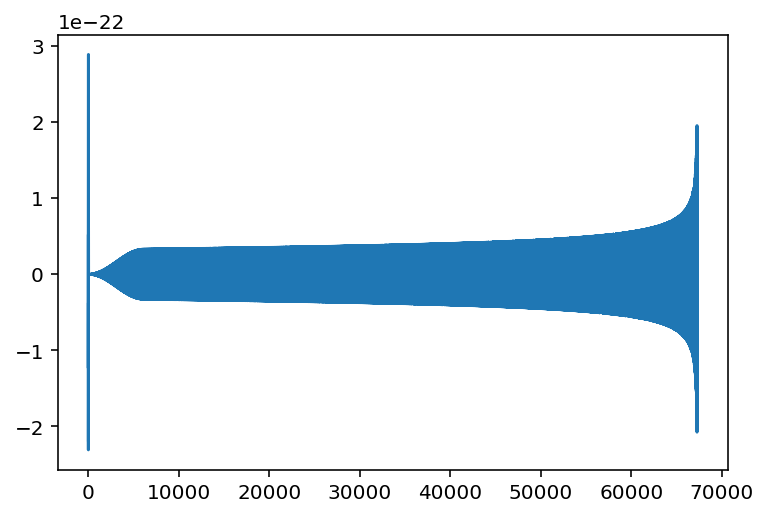

In [5]:
detector = Detector('H1')

geocent_end_time = 1187008882.4457 

# Define compact binary (component masses and distance)
mass1 = 1.48 # Msun 
mass2 = 1.26 # Msun 
distance = 40 # Mpc

# Define its geometrical parameters (sky position and other angles)
RA = 197.448*np.pi/180
dec = -23.3839*np.pi/180
iota = 50*np.pi/180
phi_ref = 0
psi = 0

# Define waveform model
approximant = "TaylorT4threePN"
amplitude_order = 0
phase_order = -1

# Define signal properties
sampling_rate = 1024 # Hz
segment_duration = 128 # s
freq_min = 30 # Hz
freq_max = sampling_rate/2.0

# Create binary            
binary = Binary(mass1, mass2, distance, ZERO, ZERO, \
                0.0, 0.0, 0, 0, iota, psi)

# Create waveform model
model = Template(approximant, amplitude_order, phase_order, sampling_rate,
                                    segment_duration, freq_min, freq_max, 0.0, phi_ref, None)

# Generate GW polarizations for that binary using that model
hplus, hcross = model.time_domain(binary)

# Project onto detector
hstrain = detector.project_strain(hplus, hcross, geocent_end_time, RA, dec, iota, psi)        

# Compute time delay wrt Earth center due to propagation
time_delay = detector.time_delay_from_earth_center(RA, dec, geocent_end_time)

# Time shift accordingly
hoft = np.roll(hstrain.data.data, int(time_delay * sampling_rate))

plot.plot(hoft)
#print(hoft[60000])
#plot.ylim(-3e-22,3e-22)
plot.savefig('GW170817test.pdf')
plot.show()


In [6]:
#fouriertransform the signal
#hoft_ft = np.fft.fft(hoft)
#plot.plot((hoft_ft))

In [10]:
#Plot the antenna function 
detector = Detector('V1')

#map resolution
n_ra = 100

ra_plot = np.linspace(-np.pi, np.pi, n_ra)
dec_plot= np.linspace(-np.pi/2, np.pi/2, n_ra)

time = 1187008882.4457  #time at GW170814
iota = np.float(0)
psi = np.float(0)

#Generate Grid for the calculation
ra, dec = np.meshgrid(ra_plot,dec_plot)

#Calculate the antenna pattern
Fplus,Fcross = detector.antenna_pattern(time, ra.flatten(), dec.flatten(), iota, psi)
F = np.sqrt(Fplus**2 + Fcross**2)

#reshape for plotting 
F = F.reshape(ra.shape)
Fplus = Fplus.reshape(ra.shape)
Fcross = Fcross.reshape(ra.shape)


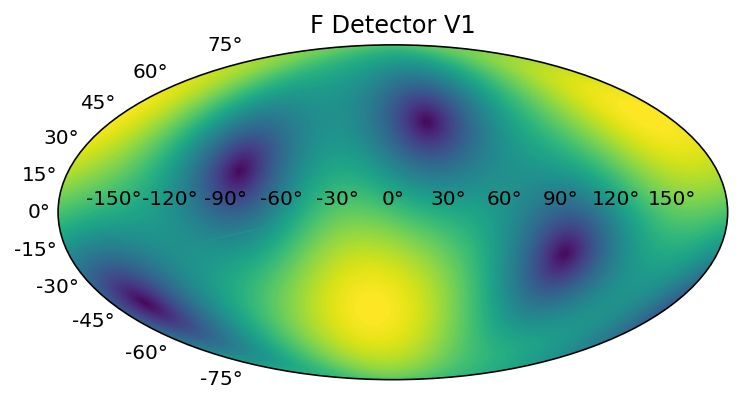

In [11]:
plot.figure()
ax = plot.subplot(111, projection = 'mollweide')
ax.contourf(ra,dec,F,200)
#plot.scatter(phi,theta,20, color = 'r')
#ax.contour(ra,dec,Zplus,10,colors='k')
#ax.grid()
plot.title('F Detector {0}'.format(detector.name))
#plot.savefig('AntennaResponseFuncFor{0}Fplus.png'.format(detector.name), dpi = 300)
plot.show()




In [15]:
def drawskymap (data, dataname = 'test',detname = '', save = 0, phi=0, theta=0):
    
    n_ra = 200

    ra_plot = np.linspace(-np.pi, np.pi, n_ra)
    dec_plot= np.linspace(-np.pi/2, np.pi/2, n_ra)
    
    plot.figure()
    ax = plot.subplot(111, projection = 'mollweide')
    ax.contourf(ra,dec,data,100)
    if(phi!=0):
        if(theta!=0):
            plot.scatter(phi,theta,20, color = 'r')
    plot.title('$F=(F_{plus}^2+F_{cross}^2)^{1/2}$ at' +' {0}'.format(detname))
    #ax.grid()
    if(save):
        plot.savefig('AntennaResponseFuncFor{0}at{1}.png'.format(dataname, detname), dpi = 100)
    plot.show()
    
def cchange (ra,dec):
    #ra and dec have to be of the form '01h18m00s' and '01d18m00s'
    c = SkyCoord(ra, dec, frame='icrs')
    if(c.ra.rad>=np.pi):
        c.ra.rad = (c.ra.rad-2*np.pi)
    theta = c.dec.rad
    phi = c.ra.rad
    return phi,theta

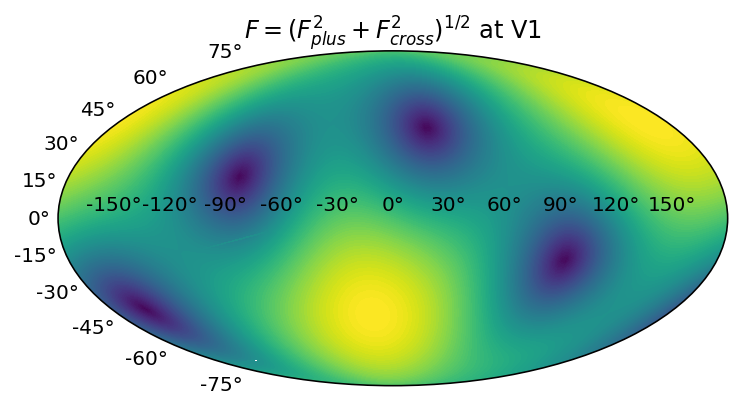

In [16]:
drawskymap(F, 'F', detector.name,12)